# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
def random_agent():
    for i in range(1, 6):                                      # play game for 5 episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
# random_agent()
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda:0


In [9]:
agent_0 = Agent(state_size=state_size, action_size=action_size, random_seed=2) # instantiate the first agent
agent_1 = Agent(state_size=state_size, action_size=action_size, random_seed=2) # instantiate the second agent
agents = [agent_0, agent_1]

In [10]:
def ddpg(n_episodes=1000, max_t=1000, print_every=100, previous_episodes=0):
    scores_deque = deque(maxlen=print_every)
    scores_history = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment
        states = env_info.vector_observations                  # get the current state (for each agent)
        for agent in agents:
            agent.reset()
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        for t in range(max_t):
            actions = agent_0.act(states, add_noise=False)
            actions[1] = agent_1.act(states, add_noise=False)[1]  # Overwrite with second agent's actions
            
            env_info = env.step(actions)[brain_name]              # send all actions to tne environment
            next_states = env_info.vector_observations            # get next state (for each agent)
            rewards = env_info.rewards                            # get reward (for each agent)
            dones = env_info.local_done                           # see if episode finished
            scores += env_info.rewards                            # update the score (for each agent)

            for a_i, agent in enumerate(agents):
                agent.step(states[a_i], actions[a_i], rewards[a_i], next_states[a_i], dones[a_i]) # Train individually

            states = next_states                                  # roll over states to next time step

            if np.any(dones):                                     # exit loop if episode finished
                break

        scores_deque.append(np.max(scores))
        scores_history.append(np.max(scores))
        print('\rEpisode {}\tAverage Max Score: {:.2f}\tAgent 0 Score: {:.2f}\tAgent 1 Score: {:.2f}'.format(
            i_episode, np.mean(scores_deque), scores[0], scores[1]), end="")
        if i_episode % print_every == 0 or i_episode == n_episodes:
            print('\rEpisode {}\tAverage Max Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            for a_i, agent in enumerate(agents):
                torch.save(agent.actor_local.state_dict(), 'checkpoints/checkpoint_actor_{}_{}.pth'.format(
                    a_i, i_episode + previous_episodes))
                torch.save(agent.critic_local.state_dict(), 'checkpoints/checkpoint_critic_{}_{}.pth'.format(
                    a_i, i_episode + previous_episodes))
        if i_episode > 100 and np.mean(scores_deque) > 0.5:
            print('\nEnvironment solved in {} episodes'.format(previous_episodes + i_episode - 100))
            print('\nEpisode {}\tAverage Max Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            for a_i, agent in enumerate(agents):
                torch.save(agent.actor_local.state_dict(), 'checkpoints/checkpoint_actor_{}_{}.pth'.format(
                    a_i, i_episode + previous_episodes))
                torch.save(agent.critic_local.state_dict(), 'checkpoints/checkpoint_critic_{}_{}.pth'.format(
                    a_i, i_episode + previous_episodes))
            break
            
    return scores_history

In [11]:
def load_agents(episode):
    # Load the trained agents
    agent_0.actor_local.load_state_dict(torch.load('checkpoints/checkpoint_actor_0_{}.pth'.format(episode)))
    agent_0.actor_target.load_state_dict(torch.load('checkpoints/checkpoint_actor_0_{}.pth'.format(episode)))
    agent_0.critic_local.load_state_dict(torch.load('checkpoints/checkpoint_critic_0_{}.pth'.format(episode)))
    agent_0.critic_target.load_state_dict(torch.load('checkpoints/checkpoint_critic_0_{}.pth'.format(episode)))
    agent_1.actor_local.load_state_dict(torch.load('checkpoints/checkpoint_actor_1_{}.pth'.format(episode)))
    agent_1.actor_target.load_state_dict(torch.load('checkpoints/checkpoint_actor_1_{}.pth'.format(episode)))
    agent_1.critic_local.load_state_dict(torch.load('checkpoints/checkpoint_critic_1_{}.pth'.format(episode)))
    agent_1.critic_target.load_state_dict(torch.load('checkpoints/checkpoint_critic_1_{}.pth'.format(episode)))

Episode 100	Average Max Score: 0.00	Agent 0 Score: 0.00	Agent 1 Score: -0.01
Episode 200	Average Max Score: 0.00	Agent 0 Score: 0.00	Agent 1 Score: -0.01
Episode 300	Average Max Score: 0.00	Agent 0 Score: -0.01	Agent 1 Score: 0.00
Episode 400	Average Max Score: 0.01	Agent 0 Score: 0.00	Agent 1 Score: -0.01
Episode 500	Average Max Score: 0.02	Agent 0 Score: 0.10	Agent 1 Score: 0.001
Episode 600	Average Max Score: 0.01	Agent 0 Score: 0.10	Agent 1 Score: 0.000
Episode 700	Average Max Score: 0.02	Agent 0 Score: 0.00	Agent 1 Score: 0.001
Episode 800	Average Max Score: 0.04	Agent 0 Score: -0.01	Agent 1 Score: 0.00
Episode 900	Average Max Score: 0.02	Agent 0 Score: -0.01	Agent 1 Score: 0.00
Episode 1000	Average Max Score: 0.01	Agent 0 Score: -0.01	Agent 1 Score: 0.00
Episode 1100	Average Max Score: 0.03	Agent 0 Score: 0.00	Agent 1 Score: -0.01
Episode 1200	Average Max Score: 0.04	Agent 0 Score: 0.10	Agent 1 Score: 0.001
Episode 1300	Average Max Score: 0.05	Agent 0 Score: 0.00	Agent 1 Score: 0

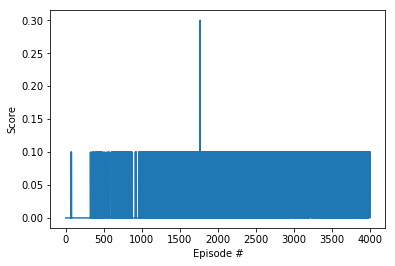

Episode 100	Average Max Score: 1.37	Agent 0 Score: 2.60	Agent 1 Score: 2.60
Episode 101	Average Max Score: 1.38	Agent 0 Score: 2.00	Agent 1 Score: 1.99
Environment solved in 4001 episodes

Episode 101	Average Max Score: 1.38


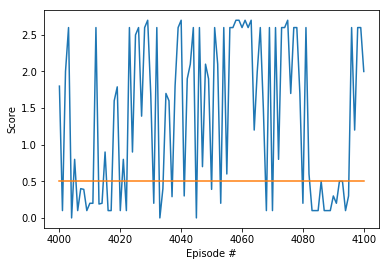

The orange line represents the "solved" criteria.


In [12]:
# load_agents() # Optionally load agents to continue training

scores = ddpg(4000, 20, 100)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

previous_episodes = len(scores)
scores = ddpg(1000, 1000, 100, previous_episodes)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(previous_episodes, previous_episodes + len(scores)), scores)
# Plot solution criteria
plt.plot(np.arange(previous_episodes, previous_episodes + len(scores)), list([0.5] * len(scores)))
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

print('The orange line represents the "solved" criteria.')

In [13]:
def run_agent():
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    step = 0
    while True:
        step += 1
        actions = agent_0.act(states, add_noise=False)
        actions[1] = agent_1.act(states, add_noise=False)[1] # Overwrite with second agent's actions
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            print("Ball lost at step: {:.2f}, Agent 0 score: {:.2f}, Agent 1 score: {:.2f}".format(
                step, scores[0], scores[1]))
            break
    print('Highest score this episode: {:.2f}'.format(np.max(scores)))

In [20]:
# Load agents for demonstration
load_agents(episode=4100)

# Watch the trained agents
run_agent()

Ball lost at step: 336.00, Agent 0 score: 0.90, Agent 1 score: 0.79
Highest score this episode: 0.90


In [21]:
env.close()